## 🏈 NFL Big Data Bowl 2024 - Proof of Concept

### Overview  
This notebook is a **proof of concept** for predicting tackles in NFL games using **Week 1 tracking data** from the NFL Big Data Bowl 2024. The goal is to build a **baseline model** and validate the **data pipeline** before expanding to more advanced feature engineering and modeling.

### Target Variable  
The target variable (`tackle_label`) is defined as **1 if a player made a tackle** and **0 otherwise**. This is determined by merging the tracking data with the official **tackles dataset**.

### Approach  
- **Use only Week 1 data** to test the pipeline.  
- **Extract and merge ball position** before filtering players.  
- **Keep only defensive players** (excluding offensive players).  
- **Train a simple XGBoost model** using relevant movement-based features.  
- **Evaluate model performance** using **F1-score and confusion matrix**.

### Next Steps  
- Expand feature engineering.  
- Tune hyperparameters and experiment with different models.  
- Scale to multiple weeks for improved generalization.  


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import os

In [52]:
print("Loading data...")
data_folder = "../data"
contents = os.listdir(data_folder)
print(contents)
# Update file paths to use data_folder
games_path = os.path.join(data_folder, 'games.csv')
plays_path = os.path.join(data_folder, 'plays.csv')
players_path = os.path.join(data_folder, 'players.csv')
week1_path = os.path.join(data_folder, 'tracking_week_1.csv')
tackles_path = os.path.join(data_folder, 'tackles.csv')

# Load the data
games = pd.read_csv(games_path)
plays = pd.read_csv(plays_path)
players = pd.read_csv(players_path)
# players = players.drop("displayName", axis=1)
tracking = pd.read_csv(week1_path)
tackles = pd.read_csv(tackles_path)

# # Ball tracking data should be added as additional information for each frame. 
# ball_tracking = tracking[tracking['displayName'] == 'football'][['gameId', 'playId', 'frameId', 'x', 'y']]
# ball_tracking = ball_tracking.rename(columns={'x': 'ball_x', 'y': 'ball_y'})
# tracking = tracking[tracking['displayName'] != 'football']
# tracking = tracking.merge(ball_tracking, on=['gameId', 'playId', 'frameId'], how='left')

print("Plays:", plays.shape, "Tackles:", tackles.shape, "Tracking:", tracking.shape)

Loading data...
['games.csv', 'players.csv', 'plays.csv', 'README.md', 'tackles.csv', 'tracking_week_1.csv', 'tracking_week_2.csv', 'tracking_week_3.csv', 'tracking_week_4.csv', 'tracking_week_5.csv', 'tracking_week_6.csv', 'tracking_week_7.csv', 'tracking_week_8.csv', 'tracking_week_9.csv']
Plays: (12486, 35) Tackles: (17426, 7) Tracking: (1407439, 17)


In [53]:

# ---------------------- Merging Datasets ---------------------- #

# Merge games with plays
joined_all = pd.merge(games, plays, how="inner", on="gameId")

# Merge tracking data with joined_all (tracking contains playId and player movement details)
joined_all = pd.merge(joined_all, tracking, how="inner", on=["gameId", "playId"])

# Merge tackles data (left join to retain all players, assuming missing means no tackle)
joined_all = pd.merge(joined_all, tackles, how="left", on=["gameId", "playId", "nflId"])

print("Merged Dataset Shape:", joined_all.shape)


Merged Dataset Shape: (1407439, 62)


In [54]:
joined_all

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore,playId,...,s,a,dis,o,dir,event,tackle,assist,forcedFumble,pff_missedTackle
0,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31,2184,...,1.79,2.80,0.17,286.97,34.95,pass_arrived,NaN,NaN,NaN,NaN
1,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31,2184,...,1.47,3.57,0.14,296.88,23.83,NaN,NaN,NaN,NaN,NaN
2,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31,2184,...,1.21,3.27,0.12,298.55,7.42,NaN,NaN,NaN,NaN,NaN
3,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31,2184,...,1.02,2.82,0.10,298.55,350.77,NaN,NaN,NaN,NaN,NaN
4,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31,2184,...,0.72,2.62,0.05,299.99,325.69,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407434,2022091200,2022,1,09/12/2022,20:15:00,SEA,DEN,17,16,3467,...,2.26,0.93,0.25,NaN,NaN,tackle,NaN,NaN,NaN,NaN
1407435,2022091200,2022,1,09/12/2022,20:15:00,SEA,DEN,17,16,3467,...,1.82,2.50,0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1407436,2022091200,2022,1,09/12/2022,20:15:00,SEA,DEN,17,16,3467,...,1.58,2.98,0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1407437,2022091200,2022,1,09/12/2022,20:15:00,SEA,DEN,17,16,3467,...,1.28,2.89,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:

# ---------------------- Handling Missing Data & Creating Target Variable ---------------------- #

# Fill NaN tackle values with 0 (Assumption: If a player's nflId is missing in tackles, they did not make a tackle)
joined_all["madeTackle"] = joined_all["nflId"].isin(tackles["nflId"]).astype(int)  # Binary target: 1 if in tackles, else 0
joined_all

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore,playId,...,a,dis,o,dir,event,tackle,assist,forcedFumble,pff_missedTackle,madeTackle
0,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31,2184,...,2.80,0.17,286.97,34.95,pass_arrived,NaN,NaN,NaN,NaN,0
1,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31,2184,...,3.57,0.14,296.88,23.83,NaN,NaN,NaN,NaN,NaN,0
2,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31,2184,...,3.27,0.12,298.55,7.42,NaN,NaN,NaN,NaN,NaN,0
3,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31,2184,...,2.82,0.10,298.55,350.77,NaN,NaN,NaN,NaN,NaN,0
4,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31,2184,...,2.62,0.05,299.99,325.69,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407434,2022091200,2022,1,09/12/2022,20:15:00,SEA,DEN,17,16,3467,...,0.93,0.25,NaN,NaN,tackle,NaN,NaN,NaN,NaN,0
1407435,2022091200,2022,1,09/12/2022,20:15:00,SEA,DEN,17,16,3467,...,2.50,0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1407436,2022091200,2022,1,09/12/2022,20:15:00,SEA,DEN,17,16,3467,...,2.98,0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1407437,2022091200,2022,1,09/12/2022,20:15:00,SEA,DEN,17,16,3467,...,2.89,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [59]:
joined_all['displayName'].value_counts()

displayName
football             61193
Josh Allen            3280
David Long            3261
Jalen Pitre           2854
Ryan Kelly            2854
                     ...  
Keisean Nixon           20
P.J. Locke              16
Eric Johnson            15
Jonathan Williams       14
J.C. Hassenauer         13
Name: count, Length: 1166, dtype: int64

In [56]:


# ---------------------- Standardizing Play Direction ---------------------- #

# Adjust coordinates for plays moving to the left
left_mask = joined_all["playDirection"] == "left"

# Flip X-coordinates: NFL field runs from 0 to 120 yards
joined_all.loc[left_mask, "x"] = 120 - joined_all.loc[left_mask, "x"]

# Flip Y-coordinates across mid-field (160/3 = ~53.3 yards width)
joined_all.loc[left_mask, "y"] = (160 / 3) - joined_all.loc[left_mask, "y"]

# Adjust orientation (o) and movement direction (dir) to maintain consistency
if "o" in joined_all.columns:
    joined_all.loc[left_mask, "o"] = (joined_all.loc[left_mask, "o"] + 180) % 360

if "dir" in joined_all.columns:
    joined_all.loc[left_mask, "dir"] = (joined_all.loc[left_mask, "dir"] + 180) % 360

print("Play direction standardized.")

Play direction standardized.


In [60]:
# ---------------------- Feature Engineering ---------------------- #

# Identify ball location at the end of the play (assumes 'football' is the team label for the ball)
ball_positions = joined_all[joined_all["displayName"] == "football"][["gameId", "playId", "x", "y"]].rename(columns={"x": "ball_x", "y": "ball_y"})

# Merge ball position onto player tracking data
joined_all = pd.merge(joined_all, ball_positions, on=["gameId", "playId"], how="left")

# Compute Euclidean distance to the ball (Potential indicator of tackle proximity)
joined_all["distance_to_ball"] = ((joined_all["x"] - joined_all["ball_x"]) ** 2 + 
                                  (joined_all["y"] - joined_all["ball_y"]) ** 2) ** 0.5

# Identify defensive players (assuming possessionTeam indicates the offensive team)
joined_all["isDefender"] = joined_all["team"] != joined_all["possessionTeam"]


MemoryError: Unable to allocate 8.78 GiB for an array with shape (17, 69307349) and data type int64

In [ ]:


# ---------------------- Final Dataset for Modeling ---------------------- #

# Filter for only defenders since we are predicting tackles
defender_plays = joined_all[joined_all["isDefender"]].copy()

# Select relevant columns for model training
model_columns = ["gameId", "playId", "nflId", "speed", "acceleration", "distance_to_ball", "madeTackle"]
model_df = defender_plays[model_columns].copy()

# Display final dataset info
print("Final Dataset Shape:", model_df.shape)
print(model_df.head())

# Save processed dataset to CSV for further model development
model_df.to_csv("data/processed_tackle_data.csv", index=False)
print("Processed dataset saved as 'processed_tackle_data.csv'")


# OSTAJ TUKA

In [41]:
joined_all = pd.merge(games,plays,how="inner",on = "gameId")
joined_all = pd.merge(joined_all, tracking,how="inner",on=["gameId","playId"])
joined_all = pd.merge(joined_all,tackles,how="left",on=["gameId","playId","nflId"])
# left join on players to keep football records
# joined_all = pd.merge(joined_all,players,how="left",on = "nflId")
# play_focus = 2184
# focused_df = joined_all[(joined_all.playId==play_focus)]
joined_all

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore,playId,...,dis,o,dir,event,ball_x,ball_y,tackle,assist,forcedFumble,pff_missedTackle
0,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31,2184,...,0.17,286.97,34.95,pass_arrived,28.020000,12.040000,NaN,NaN,NaN,NaN
1,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31,2184,...,0.14,296.88,23.83,NaN,27.190001,11.580000,NaN,NaN,NaN,NaN
2,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31,2184,...,0.12,298.55,7.42,NaN,27.250000,12.050000,NaN,NaN,NaN,NaN
3,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31,2184,...,0.10,298.55,350.77,NaN,27.320000,12.500000,NaN,NaN,NaN,NaN
4,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31,2184,...,0.05,299.99,325.69,NaN,27.370001,12.940000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346241,2022091200,2022,1,09/12/2022,20:15:00,SEA,DEN,17,16,3467,...,0.37,135.61,133.25,tackle,42.130001,19.350000,NaN,NaN,NaN,NaN
1346242,2022091200,2022,1,09/12/2022,20:15:00,SEA,DEN,17,16,3467,...,0.34,130.48,133.47,NaN,42.310001,19.309999,NaN,NaN,NaN,NaN
1346243,2022091200,2022,1,09/12/2022,20:15:00,SEA,DEN,17,16,3467,...,0.33,130.48,132.53,NaN,42.490002,19.379999,NaN,NaN,NaN,NaN
1346244,2022091200,2022,1,09/12/2022,20:15:00,SEA,DEN,17,16,3467,...,0.32,127.24,131.21,NaN,42.610001,19.459999,NaN,NaN,NaN,NaN


In [42]:
joined_all[["gameId", "playId", "ballCarrierId", "quarter", "down", "yardsToGo", "possessionTeam", "defensiveTeam", "yardlineSide", "gameClock", "absoluteYardlineNumber", "offenseFormation", "passProbability", "defendersInTheBox"
            ]]

,gameId,playId,ballCarrierId,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,gameClock,absoluteYardlineNumber,offenseFormation,passProbability,defendersInTheBox
0,2022090800,2184,42489,3,1,10,BUF,LA,LA,9:24,32,SHOTGUN,0.796962,5.0
1,2022090800,2184,42489,3,1,10,BUF,LA,LA,9:24,32,SHOTGUN,0.796962,5.0
2,2022090800,2184,42489,3,1,10,BUF,LA,LA,9:24,32,SHOTGUN,0.796962,5.0
3,2022090800,2184,42489,3,1,10,BUF,LA,LA,9:24,32,SHOTGUN,0.796962,5.0
4,2022090800,2184,42489,3,1,10,BUF,LA,LA,9:24,32,SHOTGUN,0.796962,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346241,2022091200,3467,46189,4,1,10,SEA,DEN,SEA,6:08,40,SINGLEBACK,0.298983,7.0
1346242,2022091200,3467,46189,4,1,10,SEA,DEN,SEA,6:08,40,SINGLEBACK,0.298983,7.0
1346243,2022091200,3467,46189,4,1,10,SEA,DEN,SEA,6:08,40,SINGLEBACK,0.298983,7.0
1346244,2022091200,3467,46189,4,1,10,SEA,DEN,SEA,6:08,40,SINGLEBACK,0.298983,7.0


In [37]:
print("Merging datasets...")

track_plays = tracking.merge(plays, on=['gameId', 'playId'], how='inner')

# Merge tackels with tracking data to get target variable
track_plays = track_plays.merge(tackles[['gameId', 'playId', 'nflId', 'tackle']], 
                                on=['gameId', 'playId', 'nflId'], 
                                how='left')

# 1 if the player made a tackle, 0 otherwise
track_plays['tackle_label'] = np.where(track_plays['tackle'].isna(), 0, 1)
track_plays.drop('tackle', axis=1, inplace=True)

Merging datasets...


In [39]:
track_plays

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,tackle_label
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,...,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN,0
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,...,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN,0
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,...,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN,0
3,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,88.64,...,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN,0
4,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,88.72,...,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346241,2022091200,3826,54618.0,Tariq Woolen,49,2022-09-12 23:05:57.799999,27.0,SEA,left,50.75,...,0.491006,0.282255,-0.282255,0.967420,-0.719924,NaN,NaN,NaN,NaN,0
1346242,2022091200,3826,54618.0,Tariq Woolen,50,2022-09-12 23:05:57.900000,27.0,SEA,left,50.91,...,0.491006,0.282255,-0.282255,0.967420,-0.719924,NaN,NaN,NaN,NaN,0
1346243,2022091200,3826,54618.0,Tariq Woolen,51,2022-09-12 23:05:58.000000,27.0,SEA,left,51.06,...,0.491006,0.282255,-0.282255,0.967420,-0.719924,NaN,NaN,NaN,NaN,0
1346244,2022091200,3826,54618.0,Tariq Woolen,52,2022-09-12 23:05:58.099999,27.0,SEA,left,51.19,...,0.491006,0.282255,-0.282255,0.967420,-0.719924,NaN,NaN,NaN,NaN,0


In [35]:
print("Engineering features...")

# Placeholder for full feature engineering. Right now, only using `min_dist_to_ball`
# Used as an inspiration from different notebook, euclidean distance to ball carrier.

track_plays['dist_to_ball'] = np.sqrt((track_plays['x'] - track_plays['ball_x'])**2 +
                                      (track_plays['y'] - track_plays['ball_y'])**2)

# Aggregate to get minimum distance per play/player
features_df = track_plays.groupby(['gameId', 'playId', 'nflId']).agg(
    min_dist_to_ball=('dist_to_ball', 'min')
).reset_index()

# Merge the target variable
features_df = features_df.merge(track_plays[['gameId', 'playId', 'nflId', 'tackle_label']].drop_duplicates(),
                                on=['gameId', 'playId', 'nflId'], how='left')

Engineering features...


In [36]:
features_df

,gameId,playId,nflId,min_dist_to_ball,tackle_label
0,2022090800,56,35472.0,7.334439,0
1,2022090800,56,38577.0,3.526386,0
2,2022090800,56,41239.0,6.418790,0
3,2022090800,56,42392.0,5.995406,0
4,2022090800,56,42489.0,0.094339,0
...,...,...,...,...,...
32401,2022091200,3826,52491.0,6.731806,0
32402,2022091200,3826,52526.0,3.806153,0
32403,2022091200,3826,53464.0,0.116618,0
32404,2022091200,3826,54505.0,1.087245,0


In [8]:
features_df = track_plays.groupby(['gameId', 'playId', 'nflId']).agg(
    min_dist_to_ball=('dist_to_ball', 'min')
).reset_index()
features_df

,gameId,playId,nflId,min_dist_to_ball
0,2022090800,56,35472.0,7.334439
1,2022090800,56,38577.0,3.526386
2,2022090800,56,41239.0,6.418790
3,2022090800,56,42392.0,5.995406
4,2022090800,56,42489.0,0.094339
...,...,...,...,...
32401,2022091200,3826,52491.0,6.731806
32402,2022091200,3826,52526.0,3.806153
32403,2022091200,3826,53464.0,0.116618
32404,2022091200,3826,54505.0,1.087245


In [ ]:
X

In [11]:
# Train the model

print("Splitting dataset...")
X = features_df.drop(columns=['gameId', 'playId', 'nflId', 'tackle_label'])  # Use all features
y = features_df['tackle_label']

# Train-test split (80-20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# =======================
# 5. TRAIN MODEL
# =======================
print("Training model...")
model = xgb.XGBClassifier(objective='binary:logistic', 
                          eval_metric='logloss',
                          n_estimators=100, 
                          max_depth=3, 
                          learning_rate=0.1,
                          scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),  # Balance classes
                          random_state=42)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)


Splitting dataset...
Training model...


KeyError: 0

Evaluating model...
Validation F1-score: 0.354


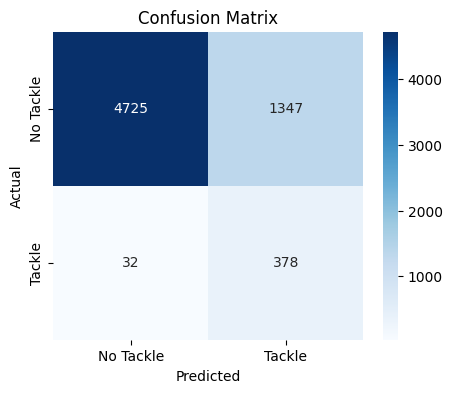

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      6072
           1       0.22      0.92      0.35       410

    accuracy                           0.79      6482
   macro avg       0.61      0.85      0.61      6482
weighted avg       0.94      0.79      0.84      6482



In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Evaluating model...")

y_pred = model.predict(X_val)
f1 = f1_score(y_val, y_pred)

print(f"Validation F1-score: {f1:.3f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Tackle', 'Tackle'], yticklabels=['No Tackle', 'Tackle'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred))